# Convolutional Neural Networks for Image Classification
### A Complete Tutorial on Training, Tuning, and Testing CNNs

In this notebook, we'll explore how to use Convolutional Neural Networks (CNNs) for image classification. We'll cover:

1. **Understanding CNNs** - What makes them powerful for image tasks
2. **Data Loading & Preprocessing** - Preparing images for training
3. **Building a CNN Architecture** - Creating the model from scratch
4. **Training** - Teaching the model to recognize patterns
5. **Hyperparameter Tuning** - Optimizing model performance
6. **Evaluation & Testing** - Assessing model accuracy
7. **Visualization** - Understanding what the model learned

We'll use the **CIFAR-10** dataset, which contains 60,000 32x32 color images in 10 classes.

## 1. Setup and Imports

In [4]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

2026-02-11 16:21:13.387164: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-11 16:21:13.388752: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-11 16:21:14.289223: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-11 16:21:20.291265: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

TensorFlow version: 2.20.0
GPU Available: []


E0000 00:00:1770844882.786749    2996 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1770844882.820705    2996 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## 2. Load and Explore the Data

CIFAR-10 consists of:
- **50,000 training images**
- **10,000 test images**
- **10 classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

In [5]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Display dataset information
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"\nPixel value range: [{X_train.min()}, {X_train.max()}]")
print(f"Number of classes: {len(class_names)}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)

Pixel value range: [0, 255]
Number of classes: 10


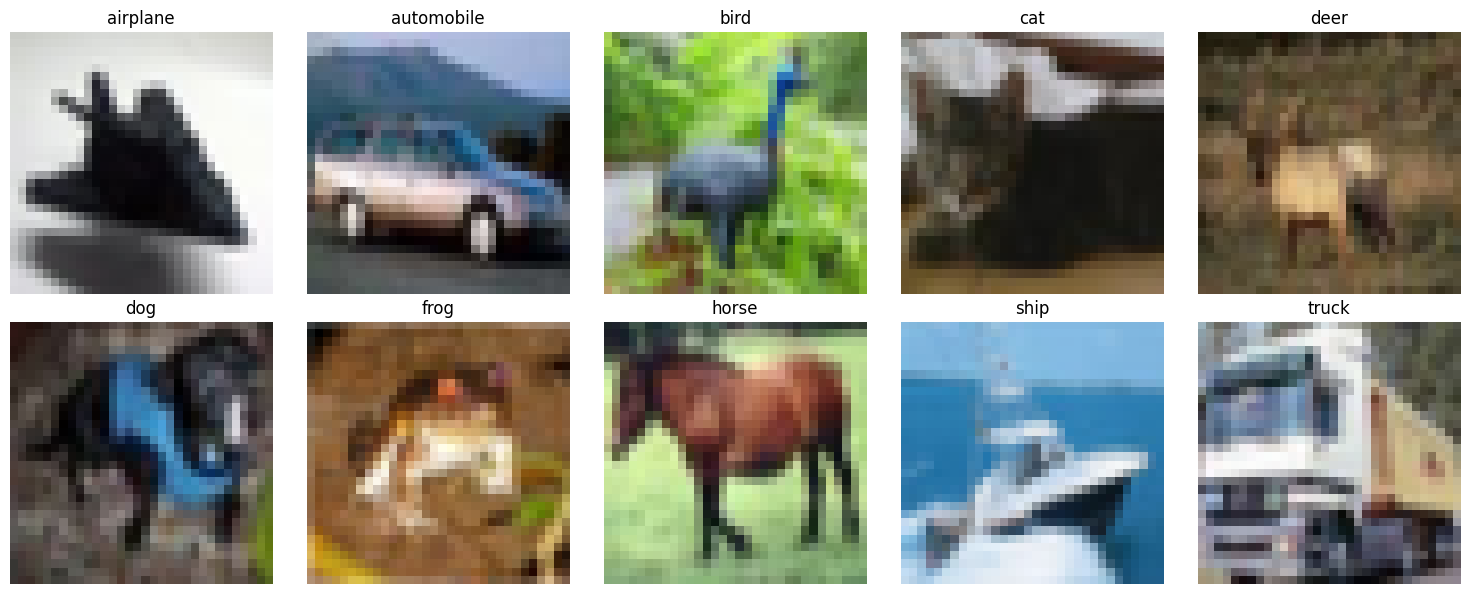

In [6]:
# Visualize sample images from each class
plt.figure(figsize=(15, 6))
for i in range(10):
    # Find first image of each class
    idx = np.where(y_train == i)[0][0]
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx])
    plt.title(class_names[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

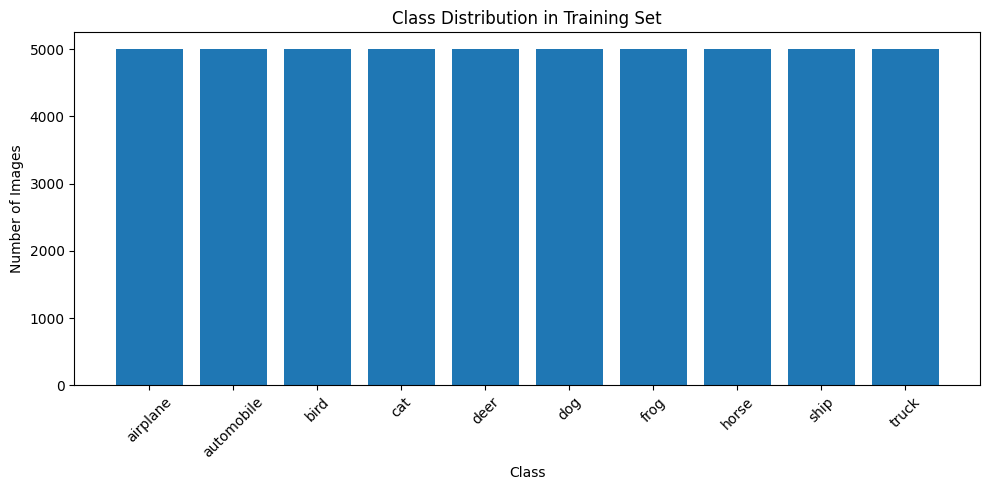

In [7]:
# Check class distribution
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar([class_names[i] for i in unique], counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [ ]:
# Normalize pixel values to [0, 1]
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

# Convert labels to categorical (one-hot encoding)
y_train_categorical = keras.utils.to_categorical(y_train, 10)
y_test_categorical = keras.utils.to_categorical(y_test, 10)

print(f"Normalized training data range: [{X_train_normalized.min():.2f}, {X_train_normalized.max():.2f}]")
print(f"Label shape before one-hot: {y_train.shape}")
print(f"Label shape after one-hot: {y_train_categorical.shape}")
print(f"\nExample label before: {y_train[0]}")
print(f"Example label after: {y_train_categorical[0]}")

(50000, 32, 32, 3) (50000, 10)
Normalized training data range: [0.00, 1.00]
Label shape before one-hot: (50000, 1)
Label shape after one-hot: (50000, 10)

Example label before: [6]
Example label after: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## 4. Building a CNN Architecture

### CNN Components:
1. **Convolutional Layers**: Extract features from images using filters
2. **Pooling Layers**: reduces the dimension of the data by 
3. **Dropout Layers**: Prevent overfitting by randomly deactivating neurons
4. **Dense Layers**: Perform final classification

### Our Architecture:
- 3 Convolutional blocks (Conv → Conv → MaxPool → Dropout)
- Flatten layer
- 2 Dense layers with dropout
- Output layer with softmax activation

In [ ]:
def create_cnn_model(input_shape=(32, 32, 3), num_classes=10, dropout_rate=0.25):
    """
    Create a CNN model for image classification
    
    Args:
        input_shape: Shape of input images (height, width, channels)
        num_classes: Number of output classes
        dropout_rate: Dropout rate for regularization
    
    Returns:
        Compiled Keras model
    """
    model = models.Sequential([
        # Exercise: fill the layers in according to the visual architecture diagram provided in the notebook
        # First Convolutional Block
        
        # Second Convolutional Block

        
        # Third Convolutional Block

        
        # Flatten and Dense Layers

        
        # Output Layer
    ])
    
    return model

# Create the model
model = create_cnn_model()

# Display model architecture
model.summary()

/home/sravan/data-science-demo/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout4 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout5 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 845,738 (3.23 MB)

 Trainable params: 845,738 (3.23 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Visualize model architecture
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, 
                       rankdir='TB', dpi=96)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## 5. Compile the Model

### Key Components:
- **Optimizer**: Adam (adaptive learning rate)
- **Loss Function**: Categorical Crossentropy (for multi-class classification)
- **Metrics**: Accuracy

In [20]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")

Model compiled successfully!


## 6. Data Augmentation

Data augmentation artificially increases training data by creating modified versions of images:
- **Random rotations**
- **Horizontal flips**
- **Width/height shifts**
- **Zoom**

This helps prevent overfitting and improves generalization.

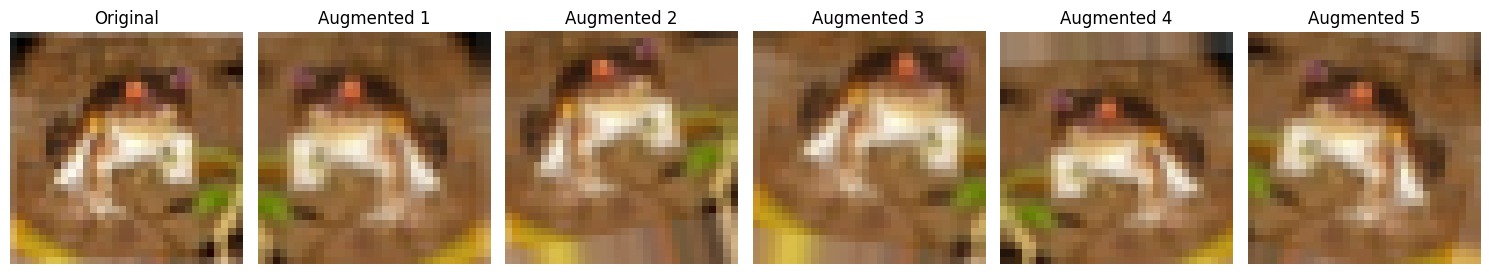

In [21]:
# Create data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# Visualize augmented images
sample_image = X_train_normalized[0:1]  # Take first image
plt.figure(figsize=(15, 3))
plt.subplot(1, 6, 1)
plt.imshow(sample_image[0])
plt.title('Original')
plt.axis('off')

# Generate 5 augmented versions
i = 2
for batch in datagen.flow(sample_image, batch_size=1):
    plt.subplot(1, 6, i)
    plt.imshow(batch[0])
    plt.title(f'Augmented {i-1}')
    plt.axis('off')
    i += 1
    if i > 6:
        break
plt.tight_layout()
plt.show()

## 7. Training with Callbacks

### Callbacks:
- **EarlyStopping**: Stop training when validation loss stops improving
- **ReduceLROnPlateau**: Reduce learning rate when validation loss plateaus

In [13]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

In [17]:
# Train the model with data augmentation
batch_size = 64
epochs = 5

history = model.fit(
    datagen.flow(X_train_normalized, y_train_categorical, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_test_normalized, y_test_categorical),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 160s 205ms/step - accuracy: 0.6084 - loss: 1.1185 - val_accuracy: 0.6417 - val_loss: 1.0133 - learning_rate: 0.0010
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 150s 192ms/step - accuracy: 0.6226 - loss: 1.0854 - val_accuracy: 0.6857 - val_loss: 0.8829 - learning_rate: 0.0010
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 206s 263ms/step - accuracy: 0.6339 - loss: 1.0649 - val_accuracy: 0.6825 - val_loss: 0.9097 - learning_rate: 0.0010
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 157s 200ms/step - accuracy: 0.6443 - loss: 1.0319 - val_accuracy: 0.7222 - val_loss: 0.8045 - learning_rate: 0.0010
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 159s 203ms/step - accuracy: 0.6525 - loss: 1.0085 - val_accuracy: 0.7199 - val_loss: 0.8196 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 4.


## 8. Visualize Training History

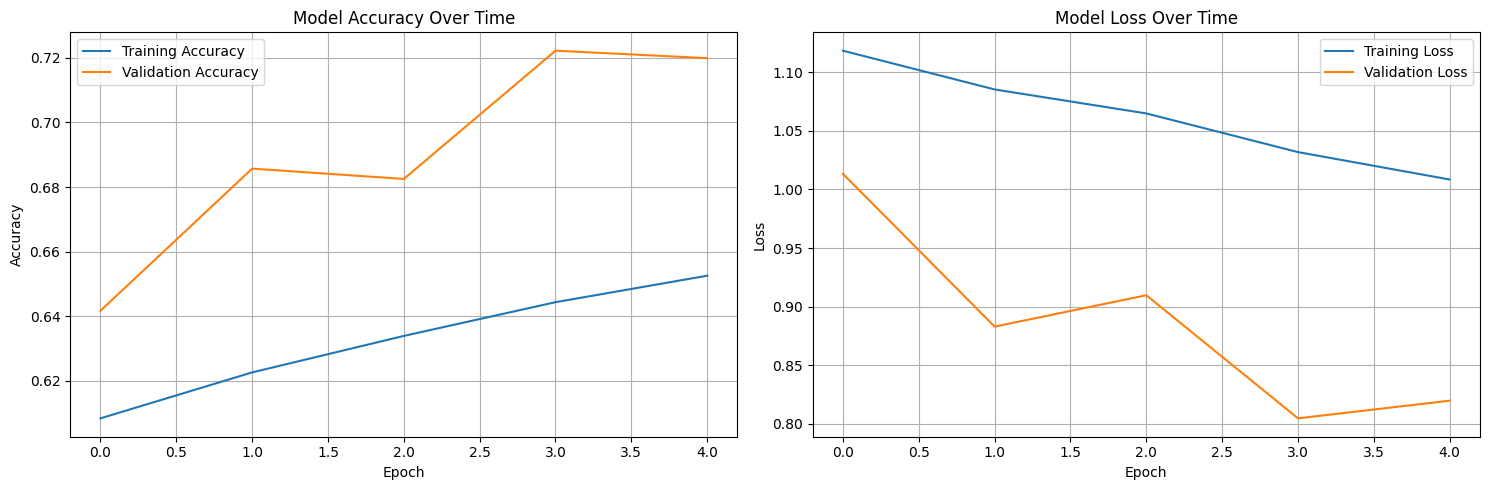


Final Training Accuracy: 0.6525
Final Validation Accuracy: 0.7199


In [18]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Over Time')
axes[0].legend()
axes[0].grid(True)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss Over Time')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

## 9. Model Evaluation on Test Set

In [22]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_normalized, y_test_categorical, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Error Rate: {(1 - test_accuracy) * 100:.2f}%")

Test Loss: 0.8045
Test Accuracy: 0.7222
Test Error Rate: 27.78%


In [23]:
# Make predictions
y_pred_probs = model.predict(X_test_normalized)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test.flatten()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.77      0.76      0.77      1000
  automobile       0.85      0.89      0.87      1000
        bird       0.76      0.44      0.56      1000
         cat       0.56      0.45      0.50      1000
        deer       0.72      0.60      0.66      1000
         dog       0.61      0.65      0.63      1000
        frog       0.65      0.87      0.74      1000
       horse       0.74      0.80      0.77      1000
        ship       0.82      0.87      0.84      1000
       truck       0.74      0.89      0.81      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.71     10000
weighted avg       0.72      0.72      0.71     10000



## 10. Confusion Matrix

In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"{class_names[i]:12s}: {acc:.4f} ({acc*100:.2f}%)")

## 11. Visualize Predictions

In [ ]:
# Visualize some predictions
def plot_predictions(images, true_labels, pred_labels, pred_probs, num_images=16):
    """
    Plot images with their true and predicted labels
    """
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    axes = axes.ravel()
    
    for i in range(num_images):
        axes[i].imshow(images[i])
        true_label = class_names[true_labels[i]]
        pred_label = class_names[pred_labels[i]]
        confidence = pred_probs[i][pred_labels[i]] * 100
        
        # Color: green if correct, red if incorrect
        color = 'green' if true_labels[i] == pred_labels[i] else 'red'
        
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%",
                         color=color, fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot random predictions
indices = np.random.choice(len(X_test), 16, replace=False)
plot_predictions(X_test[indices], y_true[indices], y_pred[indices], y_pred_probs[indices])

In [ ]:
# Show some incorrect predictions
incorrect_indices = np.where(y_pred != y_true)[0]
print(f"Number of incorrect predictions: {len(incorrect_indices)} out of {len(y_test)}")

if len(incorrect_indices) >= 16:
    sample_incorrect = np.random.choice(incorrect_indices, 16, replace=False)
    plot_predictions(X_test[sample_incorrect], y_true[sample_incorrect], 
                    y_pred[sample_incorrect], y_pred_probs[sample_incorrect])

## 12. Hyperparameter Tuning

Let's experiment with different hyperparameters to see how they affect performance.

In [ ]:
def train_and_evaluate(learning_rate=0.001, dropout_rate=0.25, batch_size=64, epochs=20):
    """
    Train a model with specific hyperparameters and return test accuracy
    """
    # Create model
    model = create_cnn_model(dropout_rate=dropout_rate)
    
    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train
    history = model.fit(
        datagen.flow(X_train_normalized, y_train_categorical, batch_size=batch_size),
        steps_per_epoch=len(X_train_normalized) // batch_size,
        epochs=epochs,
        validation_data=(X_test_normalized, y_test_categorical),
        verbose=0
    )
    
    # Evaluate
    test_loss, test_accuracy = model.evaluate(X_test_normalized, y_test_categorical, verbose=0)
    
    return test_accuracy, history

# Test different learning rates
print("Testing different learning rates...")
learning_rates = [0.0001, 0.001, 0.01]
lr_results = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    accuracy, _ = train_and_evaluate(learning_rate=lr, epochs=15)
    lr_results[lr] = accuracy
    print(f"  Test Accuracy: {accuracy:.4f}\n")

# Plot learning rate comparison
plt.figure(figsize=(10, 6))
plt.bar([str(lr) for lr in lr_results.keys()], lr_results.values())
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy')
plt.title('Effect of Learning Rate on Test Accuracy')
plt.ylim([0, 1])
plt.grid(True, alpha=0.3)
plt.show()

best_lr = max(lr_results, key=lr_results.get)
print(f"Best learning rate: {best_lr} with accuracy: {lr_results[best_lr]:.4f}")

In [ ]:
# Test different dropout rates
print("Testing different dropout rates...")
dropout_rates = [0.1, 0.25, 0.4, 0.5]
dropout_results = {}

for dr in dropout_rates:
    print(f"Training with dropout rate: {dr}")
    accuracy, _ = train_and_evaluate(dropout_rate=dr, epochs=15)
    dropout_results[dr] = accuracy
    print(f"  Test Accuracy: {accuracy:.4f}\n")

# Plot dropout rate comparison
plt.figure(figsize=(10, 6))
plt.bar([str(dr) for dr in dropout_results.keys()], dropout_results.values())
plt.xlabel('Dropout Rate')
plt.ylabel('Test Accuracy')
plt.title('Effect of Dropout Rate on Test Accuracy')
plt.ylim([0, 1])
plt.grid(True, alpha=0.3)
plt.show()

best_dropout = max(dropout_results, key=dropout_results.get)
print(f"Best dropout rate: {best_dropout} with accuracy: {dropout_results[best_dropout]:.4f}")

## 13. Visualize Learned Features (Filter Visualization)

Let's visualize what the convolutional layers have learned.

In [ ]:
# Visualize filters from the first convolutional layer
first_conv_layer = model.get_layer('conv1_1')
filters, biases = first_conv_layer.get_weights()

# Normalize filter values for visualization
f_min, f_max = filters.min(), filters.max()
filters_normalized = (filters - f_min) / (f_max - f_min)

# Plot first 32 filters
fig, axes = plt.subplots(4, 8, figsize=(15, 8))
axes = axes.ravel()

for i in range(32):
    axes[i].imshow(filters_normalized[:, :, :, i])
    axes[i].set_title(f'Filter {i+1}')
    axes[i].axis('off')

plt.suptitle('Learned Filters in First Convolutional Layer', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Visualize feature maps (activations) for a sample image
from tensorflow.keras.models import Model

# Get activations from all convolutional layers
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Get activations for a sample image
sample_idx = 0
sample_img = X_test_normalized[sample_idx:sample_idx+1]
activations = activation_model.predict(sample_img, verbose=0)

# Plot activations from first convolutional layer
first_layer_activation = activations[0]
print(f"First layer activation shape: {first_layer_activation.shape}")

fig, axes = plt.subplots(4, 8, figsize=(15, 8))
axes = axes.ravel()

for i in range(32):
    axes[i].imshow(first_layer_activation[0, :, :, i], cmap='viridis')
    axes[i].set_title(f'Feature {i+1}')
    axes[i].axis('off')

plt.suptitle(f'Feature Maps for {class_names[y_test[sample_idx][0]]} (First Conv Layer)', fontsize=16)
plt.tight_layout()
plt.show()

# Show the original image
plt.figure(figsize=(3, 3))
plt.imshow(X_test[sample_idx])
plt.title(f'Original Image: {class_names[y_test[sample_idx][0]]}')
plt.axis('off')
plt.show()

## 14. Save and Load the Model

In [ ]:
# Save the model
model.save('cnn_cifar10_model.h5')
print("Model saved as 'cnn_cifar10_model.h5'")

# Load the model
loaded_model = keras.models.load_model('cnn_cifar10_model.h5')
print("Model loaded successfully!")

# Verify loaded model works
loaded_loss, loaded_accuracy = loaded_model.evaluate(X_test_normalized, y_test_categorical, verbose=0)
print(f"Loaded model test accuracy: {loaded_accuracy:.4f}")

## 15. Summary and Key Takeaways

### What We Learned:

1. **CNNs are powerful for image classification** because they:
   - Automatically learn hierarchical features
   - Preserve spatial relationships
   - Use parameter sharing (fewer parameters than fully connected networks)

2. **Important components**:
   - Convolutional layers extract features
   - Pooling layers reduce dimensionality
   - Dropout prevents overfitting
   - Data augmentation improves generalization

3. **Hyperparameters matter**:
   - Learning rate affects convergence speed
   - Dropout rate controls regularization
   - Batch size affects training stability

4. **Best practices**:
   - Always normalize input data
   - Use callbacks (early stopping, learning rate scheduling)
   - Monitor both training and validation metrics
   - Visualize results to understand model behavior

### Next Steps:
- Try transfer learning with pre-trained models (VGG, ResNet, EfficientNet)
- Experiment with different architectures
- Apply to your own image datasets
- Explore more advanced techniques (attention mechanisms, batch normalization)

## 16. Exercises for Students

Try these modifications to deepen your understanding:

1. **Architecture Changes**:
   - Add batch normalization layers
   - Try different numbers of filters
   - Experiment with different kernel sizes

2. **Training Modifications**:
   - Train for more epochs
   - Try different optimizers (SGD, RMSprop)
   - Modify data augmentation parameters

3. **Analysis**:
   - Which classes are most often confused?
   - What patterns do the filters learn?
   - How does model depth affect performance?

4. **Transfer Learning**:
   - Use a pre-trained model (e.g., ResNet50)
   - Fine-tune on CIFAR-10
   - Compare performance with your custom CNN